# How long will Florida last?

## By Andrew Pan

This work is licensed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import matplotlib.pyplot as plt

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

import sys, pandas, datetime
from pickle import dump, load

With all of the recent hurricane activity affecting Florida, some of us are probably wondering just how many natural disasters Florida can withstand.  The recent destruction left by hurricane Matthew has displaced many people and caused numerous deaths, not to mention enormous amounts of property damage.  In this report, I will attempt to predict the probability of Florida being "wiped out" by a hurricane or tropical storm using data from the National Centers for Environmental Information's storm events database.

For the sake of simplicity, I chose to define Florida as being "wiped out" as either 10% of its population dying in a year, or the state's debt doubling in a year as a result of storms.  Florida currently has a population of 19.84 million people and a state debt of \$34.5 billion, so about 2 million people would have to die or damages caused by storms would have to total $34.5 billion within a single year to wipe Florida out.  It is important to note that these definitions are somewhat arbitrary and technically would not lead to Florida being wiped out, as the federal government provides storm relief for states.  However, these conditions being met would be nonetheless devastating for Florida.

Using the pandas library, we can open the saved csv files containing storm data for each year starting from 1980 and collect relevant data.  In this case, the data we want to collect is the number of deaths and the cost of the damage caused by each storm so we need to record these values for each event in the csv files.  One thing to note is that the data for each storm is stored as multiple events across various counties, so I made the assumption that any events occuring on the same or consecutive days were a part of the same storm, and as such all of the death and damage totals were added and stored under a single storm date, being the last day of said storm.

In [2]:
stormData = [] # list of tuples containing: (date, deaths, property damage)
curDate = datetime.datetime(1000, 1, 1) # datetime stores as year/month/day
for i in range(1980, 2016):
    df = pandas.read_csv('florida/storm' + str(i) + '.csv')
    deathSum = 0
    damageSum = 0
    for j in range(len(df['BEGIN_DATE'])):
        prevDate = curDate
        dateParams = df['BEGIN_DATE'][j].split('/')
        curDate = datetime.datetime(int(dateParams[2]), int(dateParams[0]), int(dateParams[1]))
        deathSum += int(df['DEATHS_DIRECT'][j]) + (df['DEATHS_INDIRECT'][j])
        damageSum += int(df['DAMAGE_PROPERTY_NUM'][j])
        if (curDate - prevDate).days >= 2: # the data lists damages and statistics of multiple areas from the same storm
            stormData.append((curDate, deathSum, damageSum))
            deathSum = 0
            damageSum = 0
        else:
            pass
        
    if (curDate - prevDate).days < 2:
        stormData.append((curDate, deathSum, damageSum))

Now that we have the data for all storms stored in stormData, we need to condense the data into years.  I chose to create dictionaries to store the deaths caused by storms and the frequency of storms over years.

In [3]:
yearsFrequency = {} # dictionary mapping years to the total number of storms in that year
yearsDeaths = {} # dictionary mapping years to the total number of deaths caused by storms in that year
for i in range(1980, 2016):
    yearsFrequency[i] = 0
    yearsDeaths[i] = 0
for event in stormData:
    yearsFrequency[event[0].year] += 1
    yearsDeaths[event[0].year] += event[1]

Next, we should plot all of this data to visually understand how the severity of storms is increasing.

Slope: 0.368211068211
Y-intercept: -689.084942085


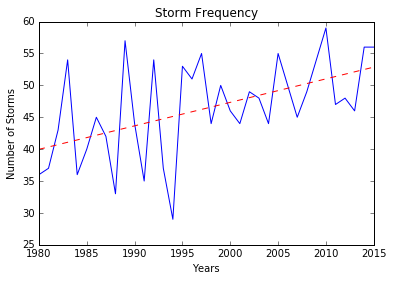

In [4]:
xFrequency = [x for x in yearsFrequency.keys()]
xFrequency.sort()
yFrequency = [yearsFrequency[x] for x in xFrequency]
plt.plot(xFrequency, yFrequency)
plt.title('Storm Frequency')
plt.xlabel('Years')
plt.ylabel('Number of Storms')
zF = np.polyfit(xFrequency, yFrequency, 1)
p = np.poly1d(zF)
plt.plot(xFrequency, p(xFrequency), 'r--')
print('Slope: ' + str(zF[0]))
print('Y-intercept: ' + str(zF[1]))

Slope: 0.284684684685
Y-intercept: -561.602102102


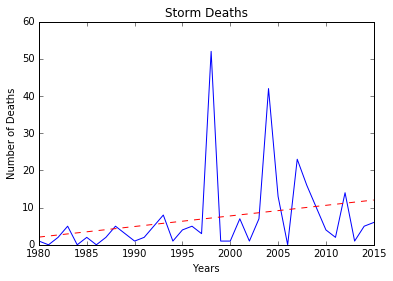

In [5]:
xDeaths = [x for x in yearsDeaths.keys()]
xDeaths.sort()
yDeaths = [yearsDeaths[x] for x in xDeaths]
plt.plot(xDeaths, yDeaths)
plt.title('Storm Deaths')
plt.xlabel('Years')
plt.ylabel('Number of Deaths')
zD = np.polyfit(xDeaths, yDeaths, 1)
p = np.poly1d(zD)
plt.plot(xDeaths, p(xDeaths), 'r--')
print('Slope: ' + str(zD[0]))
print('Y-intercept: ' + str(zD[1]))

Based on this data, it's fairly safe to say that Florida won't be wiped out in terms of population any time soon.  However, the frequency of storms does seem to be on the rise at a substantial level.  From the data plotted we obtained a linear approximation for the frequency of storms over time, of the form $y=mx+b$, for $m = .368$ and $b = -689.085$.  However, what we want to determine is the probability of Florida being destroyed by storms for a given year.  Normal linear regression can only yield a single value using the equation $y=mx+b$, but by using Bayesian linear regression we can compute the probability of a number of storms in a year, and use that probability with random sampling from the distribution of damage costs caused by storms to find a year where storm damage is probable enough to cause Florida's debt to double, meeting our condition for "wiping out" the state.

To perform Bayesian linear regression on our data for the frequency of storms over time, we need to define a set of prior hypotheses about the trend of storm frequency across years.  We have the values for $m$ and $b$ in our slope-intercept equation, and we can include add $σ$ as a parameter to account for errors within a set of standard deviations from the slope-intercept equation.  To create a range of hypothesis, we can define a range of values for $m$, $b$, and $σ$ by using np.linspace, and use the product function from itertools to enumerate all permutations of these range of values.

In [6]:
from itertools import product

# Slope: 0.368211068211
# Y-intercept: -689.084942085
slopeEstimate = zF[0]
interceptEstimate = zF[1]

slopeRange = .001
interceptRange = .001

bs = np.linspace(interceptEstimate * (1 - interceptRange), interceptEstimate * (1 + interceptRange), 40)
ms = np.linspace(slopeEstimate * (1 - slopeRange), slopeEstimate * (1 + slopeRange), 40)
sigmas = np.linspace(1, 10, 40)

hypos = product(bs, ms, sigmas)

The next step in any Bayesian problem is to update our prior hypotheses with the likelihood of each hypothesis.  In this case, we can create a class called stormFrequency that extends the Suite and Joint classes from Allen Downey's thinkbayes2 library.  The Suite class represents a probability mass function that allows for easy updating of the likelihood for each hypothesis, and the Joint class represents the distributions of multiple variables simultaneously.

In our stormFrequency class, the only function from Suite that we need to redefine is the Likelihood function.  Likelihood is called by an Update function and takes arguments for data and a hypothesis, then returns the probability of the data given the hypothesis.  To compute the likelihood of the data, we calculate the hypothesized frequency using the equation $y = mx + b$ using the $m$ and $b$ values from the current hypothesis and the year from the given data.  Next, we find the difference (or error) between the hypothesized frequency and the frequency from the data, and use the EvalNormalPdf function to compute the probability of the error given the $σ$ value for standard deviation.

After creating the stormFrequency class, we can create an instance of it with our previously defined hypotheses, and update it with all of the frequency data and determine the values of $m$, $b$, and $σ$ that produce the most likely frequency values.

In [7]:
from thinkbayes2 import EvalNormalPdf
class stormFrequency(Suite, Joint):
    '''
    data: A tuple containing the year and the number of storms during the year
    hypo: Values for b, m, and sigma for a slope-intercept equation accounting for deviations from the line
    
    returns: The probability of the data given the slope-intercept equation parameters
    '''
    def Likelihood(self, data, hypo):
        b, m, sigma = hypo
        date, frequency = data
        hypothesizedFreq = m * date + b
        error = frequency - hypothesizedFreq
        return EvalNormalPdf(error, mu=0, sigma=sigma)
    

sf = stormFrequency(hypos)

for obj in zip(xFrequency, yFrequency):
    sf.Update(obj)

In [8]:
maximum_likelihoods = {'b': 0, 'm': 0, 'σ': 0}
for title, k in [('b', 0), ('m', 1), ('σ', 2)]:
    marginal = sf.Marginal(k)
    maximum_likelihoods[title] = marginal.MaximumLikelihood()
#     thinkplot.Hist(marginal)
#     plt.title("PMF for " + title)
# plt.show()
print(maximum_likelihoods)

{'m': 0.36820162690163011, 'σ': 6.3076923076923084, 'b': -689.06727324027952}


The posterior pmfs for $b$, $m$, and $σ$ are plotted below.

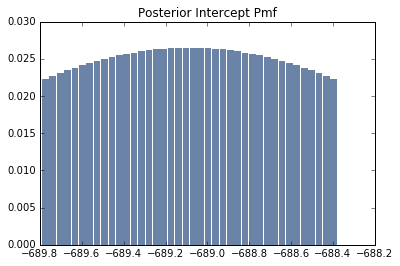

In [9]:
thinkplot.Hist(sf.Marginal(0))
plt.title('Posterior Intercept Pmf')

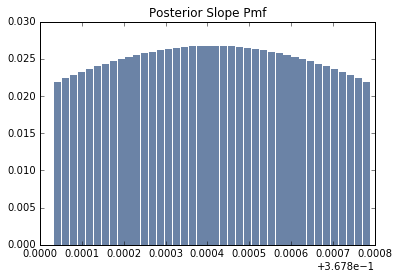

In [10]:
thinkplot.Hist(sf.Marginal(1))
plt.title('Posterior Slope Pmf')

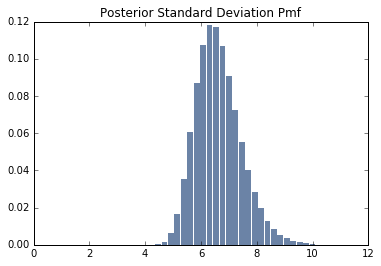

In [11]:
thinkplot.Hist(sf.Marginal(2))
plt.title('Posterior Standard Deviation Pmf')

Now that we have posterior distributions for our hypotheses, we can simulate storm frequencies by choosing a random set of hypothesis from stormFrequency using its inherited Random() function, then compute storm frequencies for several years using the hypotheses as paramters to the slope-intercept equation and plotting the new data points.

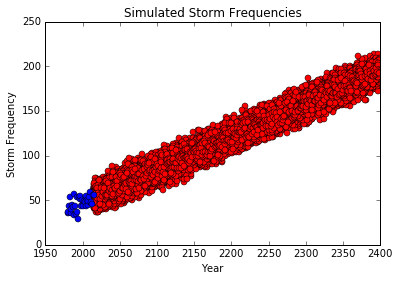

In [12]:
simulatedFrequencies = []
for i in range(100):
    b, m, sigma = sf.Random()
    simulatedFrequencies.append([(date, b + m * date + np.random.normal(scale=sigma)) for date in range(2016, 2400)])

for simulation in simulatedFrequencies:
    plt.plot([item[0] for item in simulation], [item[1] for item in simulation], 'or')
plt.plot(xFrequency, yFrequency, 'bo')
plt.title('Simulated Storm Frequencies')
plt.xlabel('Year')
plt.ylabel('Storm Frequency')

The simulated storm frequencies have quite a sizeable spread, but this is an unfortunate effect of our given storm frequency data not being very tightly correlated.  It is also difficult to discern how densely packed areas of the simulated data are because all of the points are overlayed, so we will put our data in a Joint class to get a better view of density.  The Joint class represents the distributions of multiple variables simultaneously, which are the year and storm frequency in our case.

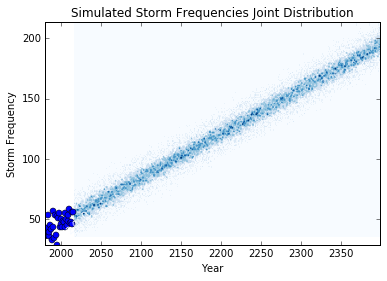

In [13]:
jointFreq = Joint()
for simulation in simulatedFrequencies:
    for date, frequency in simulation:
        jointFreq.Incr((date, round(frequency)))
thinkplot.Contour(jointFreq, contour=True, pcolor=True)
plt.plot(xFrequency, yFrequency, 'bo')
plt.title("Simulated Storm Frequencies Joint Distribution")
plt.xlabel('Year')
plt.ylabel('Storm Frequency')

Now that we have a reasonable distribution for storm frequencies over years, we can attempt to compute the total amount of damage for a given year by using random sampling from the distribution of storm damage costs.  We can begin by first plotting a histogram of the damages done by storms.

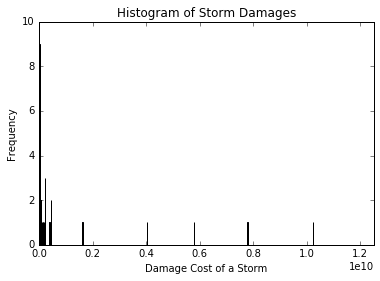

In [14]:
damages = [event[2] for event in stormData]
damagesHist = plt.hist(damages, bins = 1000)
plt.axis([0, 1.25*10**10, 0, 10])
plt.title('Histogram of Storm Damages')
plt.xlabel('Damage Cost of a Storm')
plt.ylabel('Frequency')

For the sake of visibility I set the axes to \$1.25 billion on the x-axis and 10 on the y-axis because there are actually more than a thousand entries in the first bin around \$0, and several bins spread throughout the right half of the graph that only have one entry.  In order to get a continuous distribution from this data, we can model it using a Suite.  To define the Likelihood function for this Suite, we need it to return a likelihood for the data such that data is more likely the closer to the hypothesis it is.  We can use the EvalNormalPdf function for this, which in turn calls scipy.stats.norm.pdf, returning the Pdf of the data in a normal distribution.  The parameters that we pass in are simply the data, the hypothesis (which serves as the mean for the normal distribution), and a scaling factor to normalize the value returned by scipy.stats.norm.pdf.  In this case, the scaling factor used is $10^{10}$, as this covers the range of all of the damage cost entries.

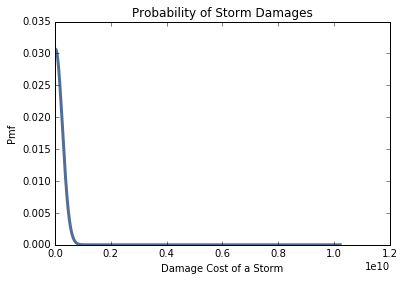

In [15]:
class damageSuite(Suite):
    def Likelihood(self, data, hypo):
        return EvalNormalPdf(data, hypo, 10 ** 10)

damagesPmf = damageSuite(damagesHist[1])
for damage in damages:
    damagesPmf.Update(damage)
thinkplot.Pdf(damagesPmf)
plt.title('Probability of Storm Damages')
plt.xlabel('Damage Cost of a Storm')
plt.ylabel('Pmf')

Finally, we can use our Weibull distribution for random sampling to determine how much damage per year is likely to be caused.  We can compute this by first determining the number of storms required within a single year to generate storm damages equal to Florida's current state debt.  To perform random sampling, we choose a random value from our Weibull distribution for each storm occurence, and average the result of this process over 500 trials for each storm frequency value.

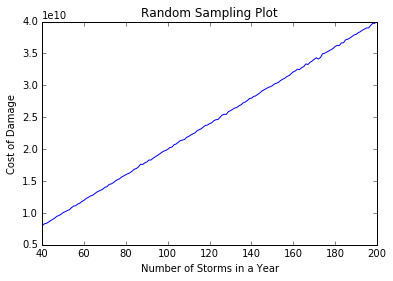

In [16]:
freqDamage = {i:0 for i in range(40, 200)}
for freq in range(40, 200):
    damageSimulation = []
    for i in range(500):
        ans = 0
        for j in range(freq):
            ans += damagesPmf.Random()
        damageSimulation.append(ans)
    freqDamage[freq] += sum(damageSimulation)/len(damageSimulation)
xFreqDamage = [x for x in freqDamage.keys()]
xFreqDamage.sort()
yFreqDamage = [freqDamage[x] for x in xFreqDamage]
plt.plot(xFreqDamage, yFreqDamage)
plt.title('Random Sampling Plot')
plt.xlabel('Number of Storms in a Year')
plt.ylabel('Cost of Damage')

The plot that results from our random sampling are mostly linear, so we can use numpy's polyfit function to obtain a slope-intercept equation.  By rearranging $y = mx + b$ to solve for x, we get $x = (y-b) / m$ to allow us to find the number of storms necessary to reach \$34.5 billion in damage costs, doubling Florida's debt.

In [17]:
zSampling = np.polyfit(xFreqDamage, yFreqDamage, 1)
print((3.45*10**10 - zSampling[1])/zSampling[0])

172.443531631


Now that we know how many storms in a year we would likely need to "wipe out" Florida, we can determine the probability of reaching a storm frequency of 360 by a given year using a Cdf.  To do this, we have to get the conditional distribution of jointFreq and use the MakeCdf() function of the returned pmf.  We can then use the Value() function of Cdf's with an argument of .9, which will return the first year in which 360 storms occur with a 90% probability.

In [18]:
frequencyCdf = jointFreq.Conditional(0, 1, 172).MakeCdf()
print(frequencyCdf.Value(.9))

2361


And there we have it, by the year 2361 there is a 90% probability of Florida being "wiped out" as a result of the financial impact of storm damages!  Of course, by that time our current standards for money and debt would likely be obsolete, but the rate of increase in the number of storms is definitely frightening!